L'obiettivo del nostro progetto è prevedere il tipo di copertura forestale basandoti su variabili cartografiche
1. Importiamo librerie

In [118]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseCategoricalCrossentropy

2. Acquisizione dei Dati
Acquisiamo i dati del nostro database e visualizziamo le sue caratteristiche

In [87]:
# Carichiamo i dati dal file CSV
data = pd.read_csv('cover_data.csv')
#Rinominiamo l'intestazione di una colonna ch epuò essere confondibile
data = data.rename(columns={'class': 'Cover_Type'})
# Visualizziamo le prime righe del DataFrame
print(data.head())
# Visualizziamo le informazioni sul DataFrame( tipo di ogni colonna, valori non-nulli e l'uso della memoria)
print(data.info())
# Visualizziamo le statistiche descrittive dei dati
print(data.describe())
# Contiamo le occorrenze di ciascun tipo di copertura forestale
print(data['Cover_Type'].value_counts())


   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238   

Considerazioni:
- dati ben organizzati, con grande varietà e non vi sono dati mancanti
- vi sono delle variabili categoriche che sono state già converite in binarie-> non ci sarà bisogno di fare modifiche
- potrebbe essere necessario un bilanciamento dei dati di addestramento per non pregiudicare il modello
- potrebbe essere utile normalizzare o standardizzare i dati

3. Suddivsione dei dati in set di addestramento, validazione e test

In [129]:
X = data.drop('Cover_Type', axis=1)  # features
y = data['Cover_Type']  # target

# Prima suddivisione: Separare i dati in set di addestramento e temp (quest'ultimo sarà poi suddiviso in validazione e test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Seconda suddivisione: Dividere i dati temp in set di validazione e test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

i nostri dati suddivisi:
- X_train, y_train - per l'addestramento
- X_val, y_val - per la validazione
- X_test, y_test - per il test

4. Pre-Elaborazione dei dati(ci vogliono 6 minuti)

4.1 Bilanciamento dei dati modello con metodo Smote 
Decidiamo di utilizzare Smote perché riesce a limitare l'overfitting

Cover_Type
2    158579
1    158579
7    158579
3    158579
6    158579
5    158579
4    158579
Name: count, dtype: int64


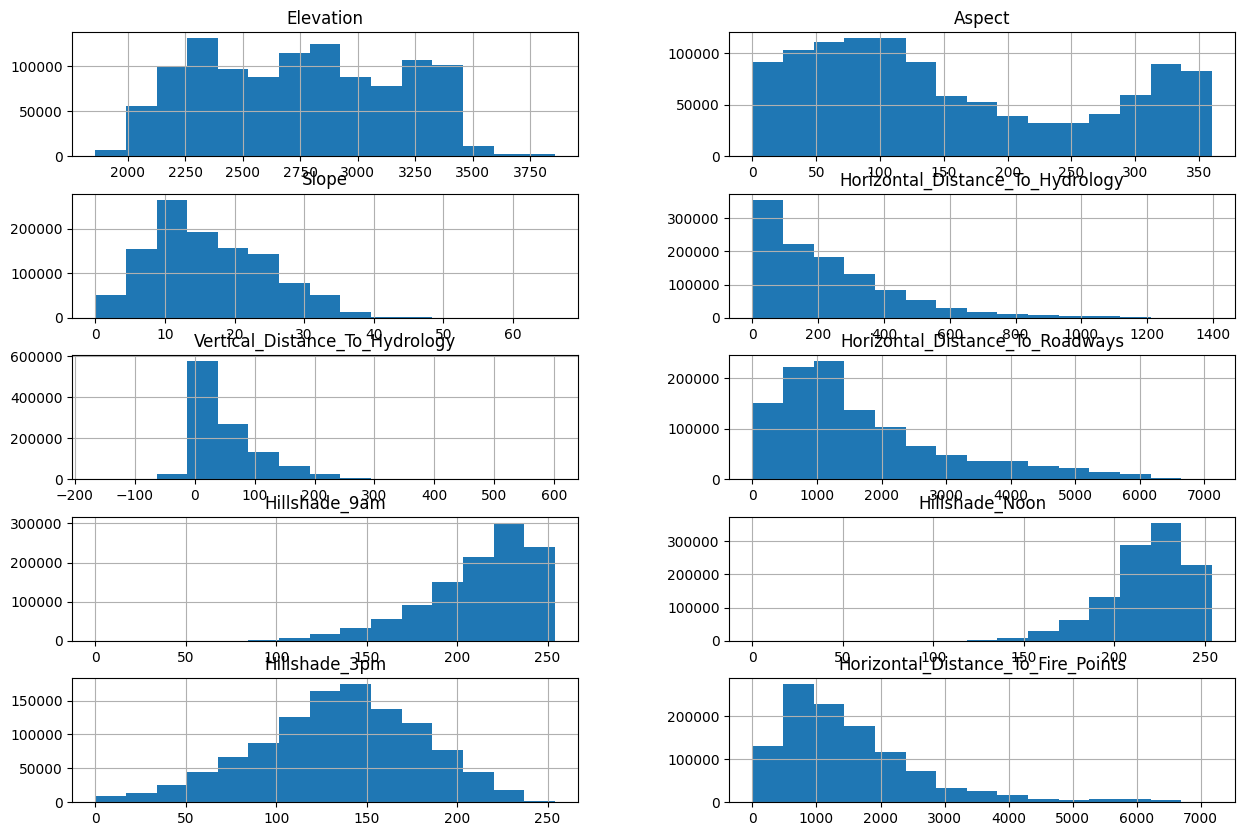

In [130]:
#Bilanciamento dei dati con SMOTE
smote = SMOTE()
X_train_res, y_train_res = smote.fit_resample(X_train_fold, y_train_fold)
quantitative_columns = [
    'Elevation', 'Aspect', 'Slope', 
    'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 
    'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
]
#visualizziamo le distribuzione delle features, è utile pre comprendere dove andare ad effettuare standardizzazione o normalizzazione
X_train_res[quantitative_columns].hist(bins=15, figsize=(15, 10), layout=(5, 2))
#verifichiamo che la distribuzione sia stata svolta, ci serve anche per conoscere quanti dati abbiamo a disposizone 
print(y_train_res.value_counts())

4.2 Standardizzazione, Noramlizzazione e trasformazione logaritmica dei dati:
- Standardizzazione: 'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'
- Trasformazione log: 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'


In [131]:
#Standardizziamo i dati 
standardize_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']
log_transform_columns = ['Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

# Creare i trasformatori per le diverse colonne
preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), standardize_columns),
        ('log', FunctionTransformer(np.log1p), log_transform_columns)  # log1p è usato per gestire il caso in cui abbiamo zero nei dati
    ],
    remainder='passthrough'  # Le altre colonne non specificate non vengono trasformate
)

# Creare un pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Adattare il pipeline ai dati di addestramento e trasformarli
X_traint = pipeline.fit_transform(X_train_res)

# Trasformare i set di validazione e test senza riadattare
X_valt = pipeline.transform(X_val)
X_testt = pipeline.transform(X_test)

#Dobbiamo effettuare anche un'altra trasformazione: in sparse_categorical_crossentropy le etichette devono partire da 0 e poi aumentare invece nel caso di Cover_Type essa parte da 1
y_train_res = y_train_res - 1
y_test = y_test - 1
y_val=y_val -1

5. Creiamo il nostro modello

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 64)                3520      
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_59 (Dense)            (None, 7)                 455       
                                                                 
Total params: 3975 (15.53 KB)
Trainable params: 3975 (15.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 64)                3520      
                                                              

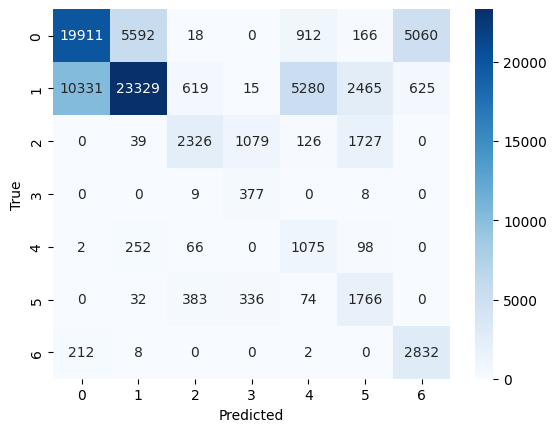

In [132]:
# Numero di feature nel tuo dataset, che dovrebbe essere 54 dopo la trasformazione
n_features = X_traint.shape[1]

# Creazione del modello
model = Sequential()

# Input Layer e primo Hidden Layer con regolarizzazione L1
model.add(Dense(64, activation='relu', input_shape=(n_features,), kernel_regularizer=l2(0.01)))

# Eventuale Dropout per la regolarizzazione
model.add(Dropout(0.6))

# Output Layer
model.add(Dense(7, activation='softmax'))  # 7 classi di copertura forestale

# Compilazione del modello
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        SparseCategoricalAccuracy(name='accuracy')
         ]
)

# Stampa del riepilogo del modello
model.summary()



# Stampa del riepilogo del modello
model.summary()

# Definisci il callback di EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitora la loss di validation
    patience=3,  # Numero di epoche senza miglioramento dopo cui interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi del modello dal punto in cui aveva la migliore loss di validation
)


# Addestramento del modello
history = model.fit(
    X_traint, y_train_res,
    validation_data=(X_valt, y_val),
    epochs=10,  # Numero di epoche
    batch_size=32,  # Dimensione del batch
    callbacks=[early_stopping]
)

y_pred_prob = model.predict(X_testt)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
# Visualizza la matrice di confusione
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [133]:
test_loss, test_accuracy = model.evaluate(X_testt, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

2724/2724 [==============================] - 1s 325us/step - loss: 0.9311 - accuracy: 0.5923
Test Loss: 0.9311341643333435
Test Accuracy: 0.5922526121139526
